# Hierarchical gradient boosting

Using a simulated data set

Custom loss

https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d

## Setup libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np

In [4]:
import sys

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [7]:
import lightgbm as lgb

In [8]:
import matplotlib.pyplot as plt

In [9]:
import arviz as az
import bambi as bmb

Couldn't import dot_parser, loading of dot files will not be possible.


In [10]:
az.style.use('arviz-darkgrid')

In [11]:
warnings.simplefilter("ignore")

## Utility functions

In [12]:
pal = sns.color_palette()

In [13]:
def print_mse_performance(model, X_test, y_test, name):
    'display mean-squared-error for fitted model'

    if isinstance(model, lgb.engine.CVBooster):
        if model.best_iteration > 0:
            y_pred_list = model.predict(
                X_test, num_iteration=model.best_iteration
            )
        else:
            y_pred_list = model.predict(X_test)
        y_pred = np.mean(np.asarray(y_pred_list), axis=0)
    else:
        y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    model_name = model.__class__.__name__
    print('{}, {}, mse = {:.3f}'.format(model_name, name, mse))

In [14]:
def plot_actual_predict(actual, predict, ax, title):
    'plot actual label vs predicted label'
    model_predict = pd.DataFrame(
        {'actual': actual, 'predict': predict, 'residual': predict - actual}
    )
    ax = sns.scatterplot(x='actual', y='predict', data=model_predict, ax=ax)
    (xmin, xmax), (ymin, ymax) = [ax.get_xlim(), ax.get_ylim()]
    min_axis, max_axis = min(xmin, ymin), max(xmax, ymax)
    ax.set_xlim(min_axis, max_axis)
    ax.set_ylim(min_axis, max_axis)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    ax.set_title(title)

In [15]:
def plot_actual_residual(actual, predict, ax, title):
    'plot actual label vs residual (predict - actual)'
    model_predict = pd.DataFrame(
        {'actual': actual, 'predict': predict, 'residual': predict - actual}
    )
    ax = sns.scatterplot(x='actual', y='residual', data=model_predict, ax=ax)
    ax.axhline(y=0, color='red', linestyle='dotted')
    ax.set_title(title)

In [16]:
def train_early_stopping_lgb(lgbm_params, lgb_train, lgb_eval):
    'train lightgbm model with early stopping'
    model = lgb.train(
        lgbm_params,
        lgb_train,
        valid_sets=lgb_eval,
        verbose_eval=-1,
        callbacks=[lgb.early_stopping(10, verbose=False)],
    )
    return model

In [17]:
def l2_loss(y, data):
    t = data.get_label()
    residual = y - t
    # loss_mult = np.where(t < 25, 10 * np.ones_like(t), 1 * np.ones_like(t))
    loss_mult = np.where(
        residual < 0, 5 * np.ones_like(t), 1 * np.ones_like(t)
    )
    grad = loss_mult * (y - t)
    hess = loss_mult * np.ones_like(y)
    return grad, hess

In [18]:
def l2_eval(y, data):
    t = data.get_label()
    residual = y - t
    # loss_mult = np.where(t < 25, 10 * np.ones_like(t), 1 * np.ones_like(t))
    loss_mult = np.where(
        residual < 0, 5 * np.ones_like(t), 1 * np.ones_like(t)
    )
    loss = loss_mult * (y - t) ** 2
    return 'l2', loss.mean(), False

In [19]:
def train_custom_loss_l2(lgbm_params, lgb_train, lgb_eval):
    'use l2 loss with a custom function'
    model = lgb.train(
        lgbm_params,
        lgb_train,
        valid_sets=lgb_eval,
        verbose_eval=-1,
        callbacks=[lgb.early_stopping(10, verbose=False)],
        fobj=l2_loss,
        feval=l2_eval,
    )
    return model

In [20]:
def train_cv_lgb(lgbm_params, lgb_train):
    'train lightgbm model with cross validation'
    cv_model = lgb.cv(
        lgbm_params,
        lgb_train,
        nfold=3,
        stratified=False,
        verbose_eval=-1,
        return_cvbooster=True,
        callbacks=[lgb.early_stopping(10, verbose=False)],
    )
    return cv_model['cvbooster']

In [21]:
def generate_data(size):
    true_intercept = 1
    true_slope1 = 1
    true_slope2 = 3

    x = np.linspace(0, 1, size)
    # y = a + b * x
    y1_true = true_intercept + true_slope1 * x
    y2_true = true_intercept + true_slope2 * x
    # add noise
    scale = 0.2
    y1 = y1_true + rng.normal(scale=scale, size=size)
    y2 = y2_true + rng.normal(scale=scale, size=size)

    return x, y1, y1_true, y2, y2_true

In [22]:
def generate_wide_data(size):
    x, y1, y1_true, y2, y2_true = generate_data(size)

    return pd.DataFrame(
        dict(x=x, y1=y1, y2=y2, y1_true=y1_true, y2_true=y2_true)
    )

In [23]:
def generate_long_data(size):
    x, y1, y1_true, y2, y2_true = generate_data(size)

    grp = np.hstack([np.repeat('a', x.shape[0]), np.repeat('b', x.shape[0])])
    x = np.hstack([x, x])
    y = np.hstack([y1, y2])
    y_true = np.hstack([y1_true, y2_true])

    return pd.DataFrame(dict(x=x, y=y, y_true=y_true, grp=grp))

In [24]:
def plot_wide_data(data):
    assert set(data.columns).issuperset(
        {'x', 'y1', 'y1_true', 'y2', 'y2_true'}
    )
    fig, ax = plt.subplots()
    sns.lineplot(x='x', y='y1_true', data=data, color=pal[0], ax=ax)
    sns.scatterplot(x='x', y='y1', data=data, color=pal[0], ax=ax)
    sns.lineplot(x='x', y='y2_true', data=data, color=pal[1], ax=ax)
    sns.scatterplot(x='x', y='y2', data=data, color=pal[1], ax=ax)

In [25]:
def plot_long_data(data):
    assert set(data.columns).issuperset({'x', 'y', 'y_true', 'grp'})
    fig, ax = plt.subplots()
    sns.lineplot(x='x', y='y_true', data=data, hue='grp', ax=ax)
    sns.scatterplot(x='x', y='y', data=data, hue='grp', ax=ax)

## Get data

In [26]:
RANDOM_SEED = 1234
rng = np.random.default_rng(RANDOM_SEED)

In [27]:
long_data = generate_long_data(100)

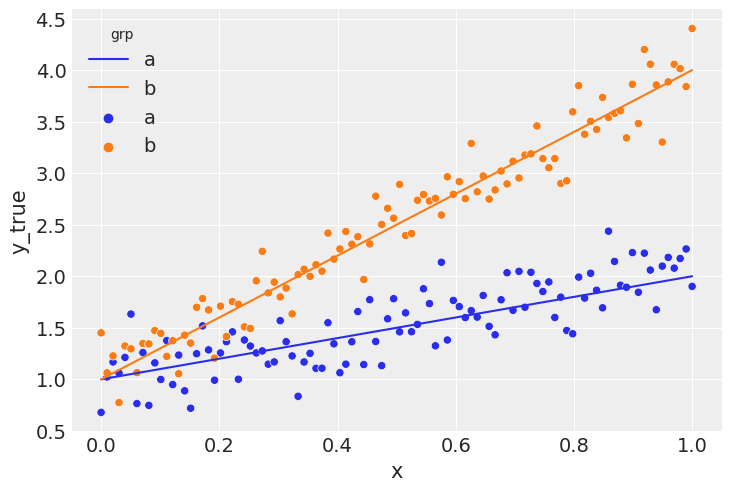

In [28]:
plot_long_data(long_data)

In [29]:
long_data.head()

,x,y,y_true,grp
0,0.000000,0.679233,1.000000,a
1,0.010101,1.022921,1.010101,a
2,0.020202,1.168380,1.020202,a
3,0.030303,1.060827,1.030303,a
4,0.040404,1.213153,1.040404,a


## Setup features, label

In [30]:
cols = ['x', 'y', 'grp']
raw_data = long_data.astype({'grp': 'category'})[cols]

In [31]:
y_data_num = raw_data.y
X_data_num = raw_data.drop(columns=['y', 'grp'])

In [32]:
y_data_cat = raw_data.y
X_data_cat = raw_data.drop(columns=['y'])

Split data into train and test

In [33]:
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X_data_num, y_data_num, test_size=0.3, random_state=0
)
lgb_train_num = lgb.Dataset(X_train_num, y_train_num)
lgb_eval_num = lgb.Dataset(X_test_num, y_test_num, reference=lgb_train_num)

In [34]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_data_cat, y_data_cat, test_size=0.3, random_state=0
)
lgb_train_cat = lgb.Dataset(X_train_cat, y_train_cat)
lgb_eval_cat = lgb.Dataset(X_test_cat, y_test_cat, reference=lgb_train_cat)

In [35]:
lgbm_params = {
    'objective': 'regression_l2',
    'learning_rate': 0.05,
    'random_seed': 0,
    'verbose': -1,
}
gbm_num = train_early_stopping_lgb(lgbm_params, lgb_train_num, lgb_eval_num)
gbm_cat = train_early_stopping_lgb(lgbm_params, lgb_train_cat, lgb_eval_cat)

In [36]:
print_mse_performance(gbm_num, X_test_num, y_test_num, 'mse_num')
print_mse_performance(gbm_cat, X_test_cat, y_test_cat, 'mse_cat')

Booster, mse_num, mse = 0.405
Booster, mse_cat, mse = 0.053


In [37]:
def plot_y_distribution():
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(12, 4), sharex=True, sharey=True
    )
    fig.suptitle('y distribution')
    sns.histplot(y_test_num, ax=ax1).set_xlabel('y_true')
    sns.histplot(gbm_num.predict(X_test_num), ax=ax2).set_xlabel('l2_num')
    sns.histplot(gbm_cat.predict(X_test_cat), ax=ax3).set_xlabel('l2_cat')

In [38]:
def plot_compare_actual_predict():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_actual_predict(y_test_num, gbm_num.predict(X_test_num), ax1, 'l2_num')
    plot_actual_predict(y_test_cat, gbm_cat.predict(X_test_cat), ax2, 'l2_cat')

In [39]:
# plot_y_distribution()
# plot_compare_actual_predict()

## Bayesian models

In [40]:
train_data = X_train_cat.assign(y=y_train_cat)

In [41]:
model = bmb.Model("y ~ x", train_data)
fitted = model.fit(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.


In [42]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.998,0.103,0.804,1.191,0.001,0.001,5121.0,2720.0,1.0
x,2.014,0.173,1.694,2.350,0.002,0.002,5097.0,2981.0,1.0
y_sigma,0.613,0.038,0.543,0.683,0.001,0.000,4991.0,2625.0,1.0


In [43]:
model2 = bmb.Model("y ~ (0 + x|grp)", raw_data)
fitted2 = model2.fit(tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x|grp_offset, x|grp_sigma, Intercept]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 49 seconds.
There were 352 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4728086597829024, but should be close to 0.8. Try to increase the number of tuning steps.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [44]:
az.summary(fitted2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.002,0.025,0.947,1.049,0.001,0.001,363.0,1098.0,1.14
x|grp_sigma,2.783,0.780,1.414,4.298,0.070,0.062,132.0,134.0,1.27
x|grp[a],1.072,0.053,0.973,1.176,0.002,0.001,638.0,1439.0,1.03
x|grp[b],3.006,0.053,2.903,3.103,0.002,0.001,973.0,1706.0,1.02
y_sigma,0.216,0.011,0.195,0.236,0.001,0.001,57.0,23.0,1.09


In [53]:
model3 = bmb.Model("y ~ (x|grp)", raw_data)
fitted3 = model3.fit(tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x|grp_offset, x|grp_sigma, 1|grp_offset, 1|grp_sigma, Intercept]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 73 seconds.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7194183529431465, but should be close to 0.8. Try to increase the number of tuning steps.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
There were 219 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7199592639552755, but should be close to 0.8. Try to increase the number of tuning steps.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [54]:
az.summary(fitted3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.018,0.156,0.759,1.390,0.021,0.017,97.0,42.0,1.08
1|grp_sigma,0.201,0.202,0.000,0.581,0.019,0.013,47.0,362.0,1.07
1|grp[a],-0.053,0.158,-0.436,0.216,0.021,0.022,103.0,50.0,1.12
1|grp[b],0.009,0.154,-0.384,0.254,0.020,0.020,89.0,45.0,1.06
x|grp_sigma,2.601,0.783,1.327,4.052,0.111,0.090,47.0,30.0,1.06
x|grp[a],1.124,0.072,0.992,1.266,0.003,0.002,679.0,1346.0,1.01
x|grp[b],2.967,0.076,2.834,3.113,0.006,0.004,143.0,885.0,1.02
y_sigma,0.217,0.011,0.197,0.236,0.002,0.001,48.0,99.0,1.06


In [45]:
# _ = az.plot_trace(fitted2)

In [46]:
betas = az.summary(fitted2)['mean']

In [47]:
beta_values = np.array([
    betas['Intercept'], betas['x|grp[a]'], betas['x|grp[b]']])

In [48]:
beta_values

array([1.002, 1.072, 3.006])

In [49]:
test_data = X_test_cat.assign(
    a=(X_test_cat.grp == 'a'),
    b=(X_test_cat.grp == 'b')
).astype(
    {'a': 'int64', 'b': 'int64'}
)[['x', 'a', 'b']].values

In [50]:
y_pred_cat2 = test_data @ beta_values

In [51]:
mse = mean_squared_error(y_test_cat, y_pred_cat2)
print('bayes mse = {:.2}'.format(mse))

bayes mse = 0.75


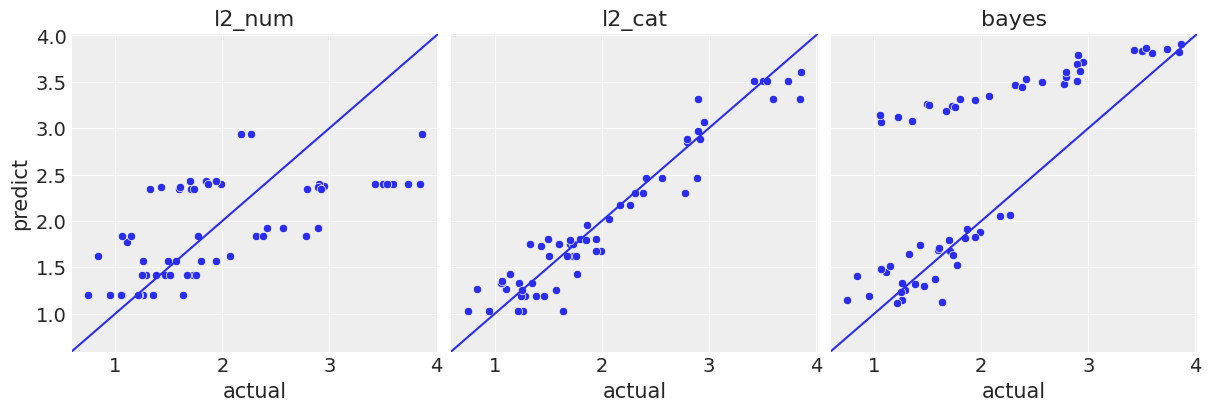

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
plot_actual_predict(y_test_num, gbm_num.predict(X_test_num), ax1, 'l2_num')
plot_actual_predict(y_test_cat, gbm_cat.predict(X_test_cat), ax2, 'l2_cat')
plot_actual_predict(y_test_cat, y_pred_cat2, ax3, 'bayes')